## Train model for all subjects

In [1]:
model_name = 'DWTs'

### Import libraries

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.feature_selection import mutual_info_classif


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss
from sklearn.model_selection import cross_validate

from matplotlib.colors import LinearSegmentedColormap
from mne import create_info
from mne.viz import plot_topomap

### Import data

In [3]:
filename = '/mnt/d/sharegit/MasterThesis_data/DWTs/pp01_t16.csv'
df = pd.read_csv(filename, header=None)

### Prepare Data

In [4]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'AFz', 'CPz', 'POz']
patterns = ['_d1', '_d2', '_d3', '_d4', '_d5', '_a1']
column_names = ['channels', 'ID', 'Class', 'Epoch'] + [f'{ch}{pt}' for ch in channels for pt in patterns]

if len(column_names) != len(df.columns):
    raise ValueError(f"Number of column names ({len(column_names)}) does not match number of columns in DataFrame ({len(df.columns)})")

df.columns = column_names
df.head()

,channels,ID,Class,Epoch,Fp1_d1,Fp1_d2,Fp1_d3,Fp1_d4,Fp1_d5,Fp1_a1,...,CPz_d3,CPz_d4,CPz_d5,CPz_a1,POz_d1,POz_d2,POz_d3,POz_d4,POz_d5,POz_a1
0,5,1,1,1,0.575075,0.136032,0.123487,0.093560,0.057901,0.013945,...,0.140594,0.042888,0.025799,0.006609,0.336483,0.220715,0.231677,0.101612,0.089528,0.019985
1,5,1,1,2,0.509184,0.262941,0.106593,0.072962,0.037227,0.011093,...,0.163608,0.041396,0.009745,0.001428,0.244889,0.384025,0.221724,0.070184,0.060243,0.018934
2,5,1,1,3,0.490340,0.191802,0.204283,0.070682,0.033491,0.009402,...,0.218914,0.044268,0.010597,0.001778,0.273779,0.215197,0.395480,0.070791,0.033080,0.011673
3,5,1,1,4,0.436777,0.235945,0.218578,0.060795,0.038248,0.009657,...,0.273868,0.036003,0.010619,0.001746,0.369812,0.265958,0.274095,0.053359,0.028603,0.008174
4,5,1,1,5,0.398432,0.307515,0.197477,0.053886,0.033593,0.009097,...,0.303220,0.038299,0.007286,0.001249,0.214284,0.327662,0.322558,0.071483,0.049477,0.014537


### Load data into data_array

In [7]:
def load_IDs(df, IDs,types,mod):
    df = df[df['Class'].isin(types)]
    
    class_mapping = dict(zip(types, mod))
    df['Class'] = df['Class'].map(class_mapping)
    
    # Filter the dataframe for the provided IDs
    df = df[df['ID'].isin(IDs)]
    
    # Drop unnecessary columns
    df = df.drop(columns=['channels', 'ID', 'Epoch'])
    
    # Prepare data and labels
    data_array = df.drop(['Class'], axis=1).values
    class_labels = df['Class'].values
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(data_array, class_labels, test_size=0.2, random_state=42)
    print(df.shape[0])
    return X_train, X_test, y_train, y_test
    
# Example usage
types = [1,2,3,4,5,6,7,8,9,10,11,12]
mod = ['Air1','Air2','Air3','Air4','Vib1','Vib2','Vib3','Vib4','Car1','Car2','Car3','Car4']
IDs = range(1, 35)
X_train, X_test, y_train, y_test = load_IDs(df, IDs,types,mod)

7548


In [8]:
print(set(IDs))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34}


### Train models

In [9]:
def print_scores(name, scores):
    mean_test_accuracy = np.mean(scores['test_accuracy']) * 100
    std_test_accuracy = np.std(scores['test_accuracy']) * 100
    mean_test_precision = np.mean(scores['test_precision_macro'])
    mean_test_recall = np.mean(scores['test_recall_macro'])
    mean_test_f1 = np.mean(scores['test_f1_macro'])
    mean_test_roc_auc = np.mean(scores['test_roc_auc_ovr'])
    
    print(f"------------------------------------------------------------")
    print(f"Average K-Fold Test Accuracy of {name}: {mean_test_accuracy:.2f}%")
    print(f"Std Dev of K-Fold Test Accuracy of {name}: {std_test_accuracy:.2f}%")
    print(f"Average K-Fold Test Precision of {name}: {mean_test_precision:.2f}")
    print(f"Average K-Fold Test Recall of {name}: {mean_test_recall:.2f}")
    print(f"Average K-Fold Test F1 Score of {name}: {mean_test_f1:.2f}")
    print(f"Average K-Fold Test ROC AUC of {name}: {mean_test_roc_auc:.2f}")
    print(f"------------------------------------------------------------")
    
def RForest_train(X_train, y_train, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', validation='standard', cv=5, echo=True):
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                      min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                      max_features=max_features, random_state=42)
    
    scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr']
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, return_train_score=True)

    model.fit(X_train, y_train)
    
    if echo:
        print_scores('Random Forest', scores)
    return scores, model


def KNN_train(X_train, y_train, hot_encode=False, n_neighbors=20, p=1, weights='distance', leaf_size=20, algorithm='auto', validation='standard', cv=5, echo=True):
    model = KNeighborsClassifier(n_neighbors=n_neighbors, p=p, weights=weights, leaf_size=leaf_size, algorithm=algorithm)

    scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr']
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, return_train_score=True)
    
    model.fit(X_train, y_train)
    
    if echo:
        print_scores('KNN', scores)
    return scores, model


def MLP_train(X_train, y_train,  hot_encode=False, hidden_layer_sizes=(100,), activation='relu', solver='adam', validation='standard', alpha=0.001, cv=5, max_iter=200, echo=True):
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, alpha=alpha, batch_size='auto', learning_rate='constant', 
                              learning_rate_init=0.001, power_t=0.5, max_iter=max_iter, shuffle=True, random_state=None, tol=0.0001, verbose=False, 
                              warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, 
                              beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)

    scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr']
    scores = cross_validate(model,X_train, y_train, cv=cv, scoring=scoring, return_train_score=True)
    
    model.fit(X_train, y_train)

    if echo:
        print_scores('MLP', scores)
    return scores, model

def train_all(X_train, y_train):

    models = []
    scores = []
    
    score, model = KNN_train(X_train, y_train, cv = 5)
    models.append(model)
    scores.append(score)
    
    score, model =RForest_train(X_train, y_train,  cv = 5)
    models.append(model)
    scores.append(score)
    
    score, model = MLP_train(X_train, y_train, hidden_layer_sizes=(200, 100, 50), max_iter=10000, alpha=0.001, cv=5)
    models.append(model)
    scores.append(score)
    
    return models, scores

models,scores = train_all(X_train, y_train)

------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 20.19%
Std Dev of K-Fold Test Accuracy of KNN: 0.80%
Average K-Fold Test Precision of KNN: 0.20
Average K-Fold Test Recall of KNN: 0.20
Average K-Fold Test F1 Score of KNN: 0.20
Average K-Fold Test ROC AUC of KNN: 0.67
------------------------------------------------------------
------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 28.49%
Std Dev of K-Fold Test Accuracy of Random Forest: 0.56%
Average K-Fold Test Precision of Random Forest: 0.29
Average K-Fold Test Recall of Random Forest: 0.28
Average K-Fold Test F1 Score of Random Forest: 0.28
Average K-Fold Test ROC AUC of Random Forest: 0.75
------------------------------------------------------------
------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 24.46%
Std Dev of K-Fold Test Accuracy of MLP: 1.13%
Average K-Fold Test Precision of 

In [10]:
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode

def calculate_acc(y_test_encoded, models):
    ensemble_preds = np.zeros((len(y_test_encoded), len(models)))
    accs = []
    # Loop over each model to get predictions and calculate individual accuracies
    for i, (model, name) in enumerate(zip(models, ['KNN', 'Random Forest','MLP'])):
        pred = model.predict(X_test)
        
        # Convert string predictions to numerical form
        pred_encoded = le.transform(pred)
        
        acc = np.mean(pred_encoded == y_test_encoded)
        accs.append(acc)
        print(f"{name} Classification Accuracy: {acc}")
        
        # Store the numerical predictions for ensemble averaging
        ensemble_preds[:, i] = pred_encoded

    # Average the predictions using mode for classification
    ensemble_final_preds_encoded = mode(ensemble_preds, axis=1)[0].flatten()
    
    # Convert numerical predictions back to string labels
    ensemble_final_preds = le.inverse_transform(ensemble_final_preds_encoded.astype(int))
    
    # Calculate the ensemble accuracy
    ensemble_acc = np.mean(ensemble_final_preds == y_test)
    print(f"Ensemble Classification Accuracy: {ensemble_acc}")
    return accs, ensemble_preds
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)
accs,ensemble_preds = calculate_acc(y_test_encoded, models)

KNN Classification Accuracy: 0.2099337748344371
Random Forest Classification Accuracy: 0.29271523178807946
MLP Classification Accuracy: 0.2801324503311258
Ensemble Classification Accuracy: 0.28211920529801326


In [11]:
print(accs[1])

0.29271523178807946


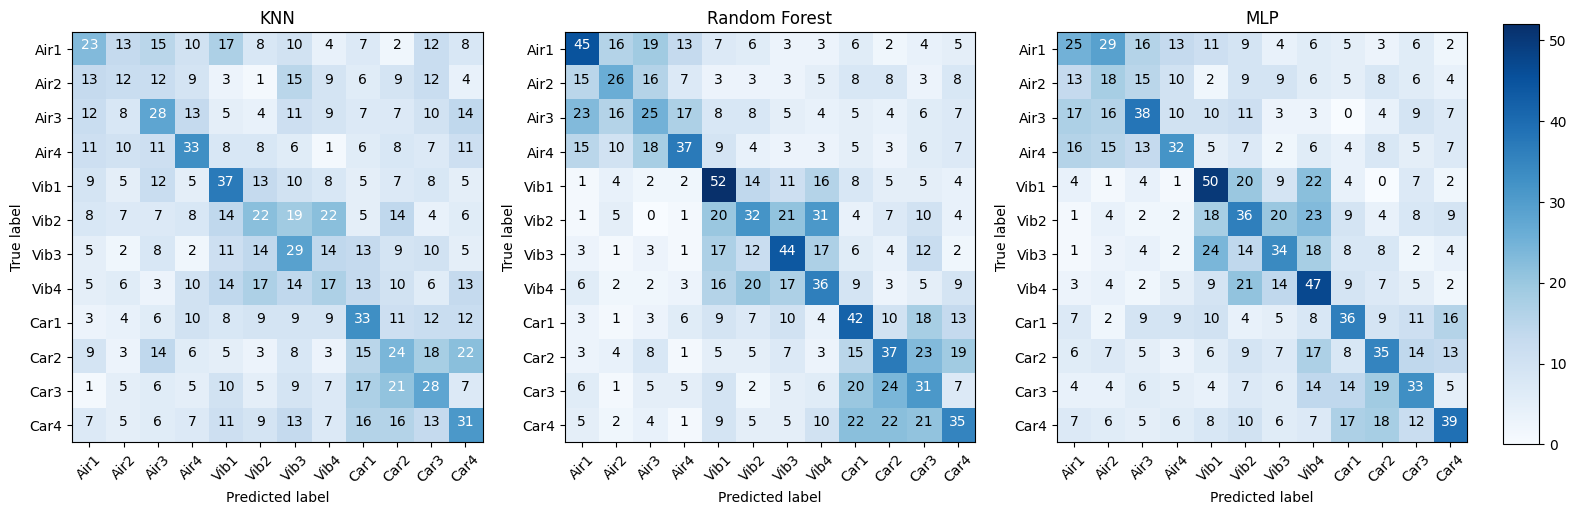

In [12]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For enhanced confusion matrix visualization

def plot_confusion_matrix(ax, cm, classes, title, vmin, vmax):
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    tick_marks = range(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_all_cm(y_test_encoded, ensemble_preds, names):
    # Compute confusion matrices
    cm_knn = confusion_matrix(y_test_encoded, ensemble_preds[:, 0])
    cm_rf = confusion_matrix(y_test_encoded, ensemble_preds[:, 1])
    cm_mlp = confusion_matrix(y_test_encoded, ensemble_preds[:, 2])
    
    # Find the global vmin and vmax for all confusion matrices
    all_cms = [cm_knn, cm_rf, cm_mlp]
    vmin = min(cm.min() for cm in all_cms)
    vmax = max(cm.max() for cm in all_cms)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot each confusion matrix with shared vmin and vmax
    plot_confusion_matrix(axes[0], cm_knn, names, 'KNN', vmin, vmax)
    plot_confusion_matrix(axes[1], cm_rf, names, 'Random Forest', vmin, vmax)
    plot_confusion_matrix(axes[2], cm_mlp, names, 'MLP', vmin, vmax)
    
    # Create a single color bar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    plt.colorbar(axes[0].images[0], cax=cbar_ax)
    plt.show()
names = ['Air1','Air2','Air3','Air4','Vib1','Vib2','Vib3','Vib4','Car1','Car2','Car3','Car4']
plot_all_cm(y_test_encoded, ensemble_preds, names)


## Features Selection

### Colormap and functions definition

In [14]:
import seaborn as sns
import os
# Define the custom colormap
cdict = {
    'red':   [(0.0, 0.0, 0.0),
              (0.33, 0.0, 0.0),
              (0.66, 1.0, 1.0),
              (1.0, 1.0, 1.0)],
    'green': [(0.0, 0.3, 0.3),  
              (0.33, 1.0, 1.0),
              (0.66, 1.0, 1.0),
              (1.0, 0.0, 0.0)],
    'blue':  [(0.0, 0.9, 0.9),  
              (0.33, 1.0, 1.0),
              (0.66, 0.0, 0.0),
              (1.0, 0.0, 0.0)]
}

custom_cmap = LinearSegmentedColormap('CustomJet', segmentdata=cdict, N=256)

def get_mutualInfo(X_train, y_train):
    mutual_info_scores = mutual_info_classif(X_train, y_train)
    selected_features = np.where(mutual_info_scores > 0)[0]
    
    X_train_sf = X_train[:, selected_features]
    X_test_sf = X_test[:, selected_features]

    channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'AFz', 'CPz', 'POz']
    patterns = ['d1', 'd2', 'd3', 'd4', 'd5', 'a1']
    feature_names = [f'{ch}_{pt}' for ch in channels for pt in patterns]
    
    scores_matrix = mutual_info_scores.reshape(len(channels), len(patterns))
    
    #print(f"Number of features selected: {len(selected_features)}")
    return scores_matrix,X_train_sf,X_test_sf
    
def plot_matrix_MI(X_train, y_train, custom_cmap, save = False, model_name = '',fig_name= ''):
    channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'AFz', 'CPz', 'POz']
    patterns = ['d1', 'd2', 'd3', 'd4', 'd5', 'a1']
    feature_names = [f'{ch}_{pt}' for ch in channels for pt in patterns]
    
    scores_matrix,X_train_sf,X_test_sf = get_mutualInfo(X_train, y_train)
    scores_df = pd.DataFrame(scores_matrix, index=channels, columns=patterns)
    plt.figure(figsize=(10, 8))
    sns.heatmap(scores_df, annot=True, fmt=".3f", cmap=custom_cmap)
    plt.title('Heatmap of Mutual Information Scores')
    plt.xlabel('Patterns')
    plt.ylabel('Channels')
    plt.show()
    if save:
        plt.savefig(f'/mnt/d/sharegit/MasterThesis_data/{model_name}/{fig_name}.png')

scores_matrix, X_train_sf, X_test_sf = get_mutualInfo(X_train, X_test, y_train)
print("Scores matrix:\n", scores_matrix)
print("Selected features (train):\n", X_train_sf.shape)
print("Selected features (test):\n", X_test_sf.shape)

TypeError: get_mutualInfo() takes 2 positional arguments but 3 were given

### Plot Matrix Mutual information

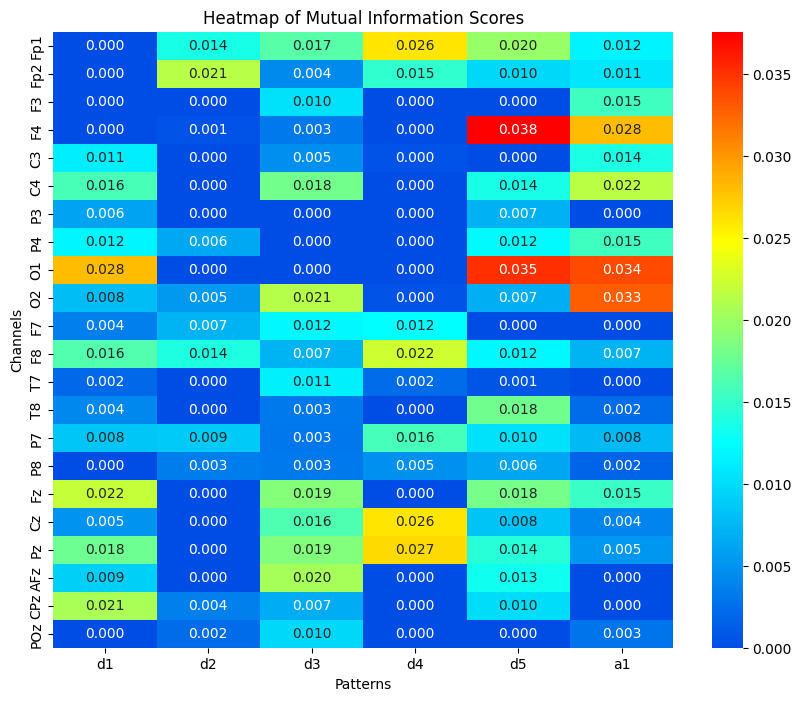

<Figure size 640x480 with 0 Axes>

In [15]:
plot_matrix_MI(X_train, y_train, custom_cmap,save = True, model_name = model_name, fig_name = 'all_subs_confmat')

### Plot as channel location 

In [18]:
channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'AFz', 'CPz', 'POz']

# Create info structure
info = create_info(channels, sfreq=250, ch_types='eeg')
info.set_montage(montage = "standard_1020",match_alias = True)

plot_topoplot(X_train, y_train, info, custom_cmap,save = True,  model_name = model_name, fig_name = 'all_subs_topoplot')


NameError: name 'plot_topoplot' is not defined

## Summarized analysis

### Initialize parameters

In [19]:
# Initialize the LabelEncoder
le = LabelEncoder()

# Create info structure
channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'AFz', 'CPz', 'POz']
info = create_info(channels, sfreq=250, ch_types='eeg')
info.set_montage(montage="standard_1020", match_alias=True)

# Initialize the DataFrame list for storing results
df_ids_list = []

### Train models for each subjects

In [21]:
# Loop through IDs
for ID in range(1,35):
    try:
        ID = [ID]
        X_train, X_test, y_train, y_test = load_IDs(df, ID, types, mod)
        models, scores = train_all(X_train, y_train)
        y_test_encoded = le.fit_transform(y_test)
        accs,ensemble_preds = calculate_acc(y_test_encoded, models)    
        # Append results to the list
        for i, type_test in enumerate(['KNN', 'RF', 'MLP']):
            df_ids_list.append([
                ID[0],
                type_test,
                scores[i]['test_accuracy'].mean(),
                np.std(scores[i]['test_accuracy']),
                scores[i]['test_precision_macro'].mean(),
                scores[i]['test_recall_macro'].mean(),
                scores[i]['test_f1_macro'].mean(),
                scores[i]['test_roc_auc_ovr'].mean(),
                accs[i]
            ])
    except:
        df_ids_list.append([
            ID[0],
            np.nan,
            np.nan,
            np.nan,
            np.nan,
            np.nan,
            np.nan,
            np.nan,
            np.nan
        ])
    
    # Plot and save topoplot
    #fig_name = 'topoplot_' + str(ID[0])
    #plot_topoplot(X_train, y_train, info, custom_cmap, save=True, model_name=model_name, fig_name=fig_name)

# Create the DataFrame from the list
df_ids = pd.DataFrame(df_ids_list, columns=['ID', 'test', 'acc', 'test_std','precision', 'recall', 'F1', 'ROC', 'test_acc'])

138
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 14.55%
Std Dev of K-Fold Test Accuracy of KNN: 6.03%
Average K-Fold Test Precision of KNN: 0.11
Average K-Fold Test Recall of KNN: 0.13
Average K-Fold Test F1 Score of KNN: 0.10
Average K-Fold Test ROC AUC of KNN: nan
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 19.09%
Std Dev of K-Fold Test Accuracy of Random Forest: 7.27%
Average K-Fold Test Precision of Random Forest: 0.21
Average K-Fold Test Recall of Random Forest: 0.21
Average K-Fold Test F1 Score of Random Forest: 0.19
Average K-Fold Test ROC AUC of Random Forest: nan
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:

------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 19.09%
Std Dev of K-Fold Test Accuracy of MLP: 9.27%
Average K-Fold Test Precision of MLP: 0.15
Average K-Fold Test Recall of MLP: 0.19
Average K-Fold Test F1 Score of MLP: 0.15
Average K-Fold Test ROC AUC of MLP: nan
------------------------------------------------------------
KNN Classification Accuracy: 0.25
Random Forest Classification Accuracy: 0.25
MLP Classification Accuracy: 0.35714285714285715
Ensemble Classification Accuracy: 0.35714285714285715
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 21.50%
Std Dev of K-Fold Test Accuracy of KNN: 6.33%
Average K-Fold Test Precision of KNN: 0.24
Average K-Fold Test Recall of KNN: 0.22
Average K-Fold Test F1 Score of KNN: 0.20
Average K-Fold Test ROC AUC of KNN: 0.63
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 30.27%
Std Dev of K-Fold Test Accuracy of Random Forest: 4.23%
Average K-Fold Test Precision of Random Forest: 0.25
Average K-Fold Test Recall of Random Forest: 0.30
Average K-Fold Test F1 Score of Random Forest: 0.26
Average K-Fold Test ROC AUC of Random Forest: 0.73
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 32.94%
Std Dev of K-Fold Test Accuracy of MLP: 7.10%
Average K-Fold Test Precision of MLP: 0.33
Average K-Fold Test Recall of MLP: 0.33
Average K-Fold Test F1 Score of MLP: 0.31
Average K-Fold Test ROC AUC of MLP: 0.72
------------------------------------------------------------
KNN Classification Accuracy: 0.1956521739130435
Random Forest Classification Accuracy: 0.30434782608695654
MLP Classification Accuracy: 0.21739130434782608
Ensemble Classification Accuracy: 0.21739130434782608
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 40.11%
Std Dev of K-Fold Test Accuracy of KNN: 5.91%
Average K-Fold Test Precision of KNN: 0.38
Average K-Fold Test Recall of KNN: 0.39
Average K-Fold Test F1 Score of KNN: 0.36
Average K-Fold Test ROC AUC of KNN: 0.90
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 53.20%
Std Dev of K-Fold Test Accuracy of Random Forest: 11.85%
Average K-Fold Test Precision of Random Forest: 0.54
Average K-Fold Test Recall of Random Forest: 0.52
Average K-Fold Test F1 Score of Random Forest: 0.50
Average K-Fold Test ROC AUC of Random Forest: 0.94
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 49.41%
Std Dev of K-Fold Test Accuracy of MLP: 5.05%
Average K-Fold Test Precision of MLP: 0.48
Average K-Fold Test Recall of MLP: 0.48
Average K-Fold Test F1 Score of MLP: 0.46
Average K-Fold Test ROC AUC of MLP: 0.89
------------------------------------------------------------
KNN Classification Accuracy: 0.1956521739130435
Random Forest Classification Accuracy: 0.41304347826086957
MLP Classification Accuracy: 0.5217391304347826
Ensemble Classification Accuracy: 0.43478260869565216
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 23.12%
Std Dev of K-Fold Test Accuracy of KNN: 5.60%
Average K-Fold Test Precision of KNN: 0.19
Average K-Fold Test Recall of KNN: 0.23
Average K-Fold Test F1 Score of KNN: 0.19
Average K-Fold Test ROC AUC of KNN: 0.76
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 59.86%
Std Dev of K-Fold Test Accuracy of Random Forest: 5.30%
Average K-Fold Test Precision of Random Forest: 0.62
Average K-Fold Test Recall of Random Forest: 0.59
Average K-Fold Test F1 Score of Random Forest: 0.57
Average K-Fold Test ROC AUC of Random Forest: 0.93
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 45.72%
Std Dev of K-Fold Test Accuracy of MLP: 8.98%
Average K-Fold Test Precision of MLP: 0.48
Average K-Fold Test Recall of MLP: 0.45
Average K-Fold Test F1 Score of MLP: 0.44
Average K-Fold Test ROC AUC of MLP: 0.88
------------------------------------------------------------
KNN Classification Accuracy: 0.17391304347826086
Random Forest Classification Accuracy: 0.45652173913043476
MLP Classification Accuracy: 0.41304347826086957
Ensemble Classification Accuracy: 0.45652173913043476
206
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 42.61%
Std Dev of K-Fold Test Accuracy of KNN: 6.58%
Average K-Fold Test Precision of KNN: 0.45
Average K-Fold Test Recall of KNN: 0.42
Average K-Fold Test F1 Score of KNN: 0.39
Average K-Fold Test ROC AUC of KNN: 0.82
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 68.88%
Std Dev of K-Fold Test Accuracy of Random Forest: 4.58%
Average K-Fold Test Precision of Random Forest: 0.71
Average K-Fold Test Recall of Random Forest: 0.68
Average K-Fold Test F1 Score of Random Forest: 0.66
Average K-Fold Test ROC AUC of Random Forest: 0.96
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 67.03%
Std Dev of K-Fold Test Accuracy of MLP: 9.26%
Average K-Fold Test Precision of MLP: 0.69
Average K-Fold Test Recall of MLP: 0.68
Average K-Fold Test F1 Score of MLP: 0.65
Average K-Fold Test ROC AUC of MLP: 0.95
------------------------------------------------------------
KNN Classification Accuracy: 0.2619047619047619
Random Forest Classification Accuracy: 0.7142857142857143
MLP Classification Accuracy: 0.7857142857142857
Ensemble Classification Accuracy: 0.6190476190476191
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 15.92%
Std Dev of K-Fold Test Accuracy of KNN: 4.36%
Average K-Fold Test Precision of KNN: 0.13
Average K-Fold Test Recall of KNN: 0.16
Average K-Fold Test F1 Score of KNN: 0.13
Average K-Fold Test ROC AUC of KNN: 0.67
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 39.53%
Std Dev of K-Fold Test Accuracy of Random Forest: 7.13%
Average K-Fold Test Precision of Random Forest: 0.38
Average K-Fold Test Recall of Random Forest: 0.40
Average K-Fold Test F1 Score of Random Forest: 0.37
Average K-Fold Test ROC AUC of Random Forest: 0.86
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 30.77%
Std Dev of K-Fold Test Accuracy of MLP: 3.17%
Average K-Fold Test Precision of MLP: 0.33
Average K-Fold Test Recall of MLP: 0.32
Average K-Fold Test F1 Score of MLP: 0.30
Average K-Fold Test ROC AUC of MLP: 0.83
------------------------------------------------------------
KNN Classification Accuracy: 0.15217391304347827
Random Forest Classification Accuracy: 0.43478260869565216
MLP Classification Accuracy: 0.41304347826086957
Ensemble Classification Accuracy: 0.391304347826087
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 20.81%
Std Dev of K-Fold Test Accuracy of KNN: 7.06%
Average K-Fold Test Precision of KNN: 0.21
Average K-Fold Test Recall of KNN: 0.21
Average K-Fold Test F1 Score of KNN: 0.19
Average K-Fold Test ROC AUC of KNN: 0.74
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 19.74%
Std Dev of K-Fold Test Accuracy of Random Forest: 4.55%
Average K-Fold Test Precision of Random Forest: 0.19
Average K-Fold Test Recall of Random Forest: 0.19
Average K-Fold Test F1 Score of Random Forest: 0.18
Average K-Fold Test ROC AUC of Random Forest: 0.78
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 24.13%
Std Dev of K-Fold Test Accuracy of MLP: 4.11%
Average K-Fold Test Precision of MLP: 0.24
Average K-Fold Test Recall of MLP: 0.23
Average K-Fold Test F1 Score of MLP: 0.23
Average K-Fold Test ROC AUC of MLP: 0.80
------------------------------------------------------------
KNN Classification Accuracy: 0.2391304347826087
Random Forest Classification Accuracy: 0.1956521739130435
MLP Classification Accuracy: 0.2826086956521739
Ensemble Classification Accuracy: 0.2391304347826087
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 27.42%
Std Dev of K-Fold Test Accuracy of KNN: 5.43%
Average K-Fold Test Precision of KNN: 0.27
Average K-Fold Test Recall of KNN: 0.27
Average K-Fold Test F1 Score of KNN: 0.23
Average K-Fold Test ROC AUC of KNN: 0.79
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 47.25%
Std Dev of K-Fold Test Accuracy of Random Forest: 6.71%
Average K-Fold Test Precision of Random Forest: 0.53
Average K-Fold Test Recall of Random Forest: 0.48
Average K-Fold Test F1 Score of Random Forest: 0.46
Average K-Fold Test ROC AUC of Random Forest: 0.91
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 39.05%
Std Dev of K-Fold Test Accuracy of MLP: 8.76%
Average K-Fold Test Precision of MLP: 0.41
Average K-Fold Test Recall of MLP: 0.40
Average K-Fold Test F1 Score of MLP: 0.38
Average K-Fold Test ROC AUC of MLP: 0.87
------------------------------------------------------------
KNN Classification Accuracy: 0.32608695652173914
Random Forest Classification Accuracy: 0.5652173913043478
MLP Classification Accuracy: 0.6086956521739131
Ensemble Classification Accuracy: 0.5
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 20.35%
Std Dev of K-Fold Test Accuracy of KNN: 3.39%
Average K-Fold Test Precision of KNN: 0.17
Average K-Fold Test Recall of KNN: 0.19
Average K-Fold Test F1 Score of KNN: 0.17
Average K-Fold Test ROC AUC of KNN: 0.66
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 39.58%
Std Dev of K-Fold Test Accuracy of Random Forest: 6.07%
Average K-Fold Test Precision of Random Forest: 0.38
Average K-Fold Test Recall of Random Forest: 0.38
Average K-Fold Test F1 Score of Random Forest: 0.36
Average K-Fold Test ROC AUC of Random Forest: 0.82
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 29.74%
Std Dev of K-Fold Test Accuracy of MLP: 6.21%
Average K-Fold Test Precision of MLP: 0.33
Average K-Fold Test Recall of MLP: 0.29
Average K-Fold Test F1 Score of MLP: 0.29
Average K-Fold Test ROC AUC of MLP: 0.76
------------------------------------------------------------
KNN Classification Accuracy: 0.13043478260869565
Random Forest Classification Accuracy: 0.1956521739130435
MLP Classification Accuracy: 0.21739130434782608
Ensemble Classification Accuracy: 0.17391304347826086
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 14.31%
Std Dev of K-Fold Test Accuracy of KNN: 3.32%
Average K-Fold Test Precision of KNN: 0.10
Average K-Fold Test Recall of KNN: 0.14
Average K-Fold Test F1 Score of KNN: 0.11
Average K-Fold Test ROC AUC of KNN: 0.59
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 31.86%
Std Dev of K-Fold Test Accuracy of Random Forest: 4.43%
Average K-Fold Test Precision of Random Forest: 0.36
Average K-Fold Test Recall of Random Forest: 0.34
Average K-Fold Test F1 Score of Random Forest: 0.33
Average K-Fold Test ROC AUC of Random Forest: 0.79
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 20.38%
Std Dev of K-Fold Test Accuracy of MLP: 4.33%
Average K-Fold Test Precision of MLP: 0.19
Average K-Fold Test Recall of MLP: 0.20
Average K-Fold Test F1 Score of MLP: 0.18
Average K-Fold Test ROC AUC of MLP: 0.69
------------------------------------------------------------
KNN Classification Accuracy: 0.06521739130434782
Random Forest Classification Accuracy: 0.21739130434782608
MLP Classification Accuracy: 0.1956521739130435
Ensemble Classification Accuracy: 0.13043478260869565
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 12.66%
Std Dev of K-Fold Test Accuracy of KNN: 2.32%
Average K-Fold Test Precision of KNN: 0.12
Average K-Fold Test Recall of KNN: 0.12
Average K-Fold Test F1 Score of KNN: 0.10
Average K-Fold Test ROC AUC of KNN: 0.53
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 29.65%
Std Dev of K-Fold Test Accuracy of Random Forest: 5.18%
Average K-Fold Test Precision of Random Forest: 0.24
Average K-Fold Test Recall of Random Forest: 0.29
Average K-Fold Test F1 Score of Random Forest: 0.26
Average K-Fold Test ROC AUC of Random Forest: 0.68
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 17.03%
Std Dev of K-Fold Test Accuracy of MLP: 2.00%
Average K-Fold Test Precision of MLP: 0.19
Average K-Fold Test Recall of MLP: 0.17
Average K-Fold Test F1 Score of MLP: 0.17
Average K-Fold Test ROC AUC of MLP: 0.60
------------------------------------------------------------
KNN Classification Accuracy: 0.10869565217391304
Random Forest Classification Accuracy: 0.2391304347826087
MLP Classification Accuracy: 0.2391304347826087
Ensemble Classification Accuracy: 0.1956521739130435
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 11.49%
Std Dev of K-Fold Test Accuracy of KNN: 4.22%
Average K-Fold Test Precision of KNN: 0.12
Average K-Fold Test Recall of KNN: 0.12
Average K-Fold Test F1 Score of KNN: 0.11
Average K-Fold Test ROC AUC of KNN: 0.54
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 17.58%
Std Dev of K-Fold Test Accuracy of Random Forest: 3.71%
Average K-Fold Test Precision of Random Forest: 0.16
Average K-Fold Test Recall of Random Forest: 0.17
Average K-Fold Test F1 Score of Random Forest: 0.15
Average K-Fold Test ROC AUC of Random Forest: 0.73
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 14.82%
Std Dev of K-Fold Test Accuracy of MLP: 5.08%
Average K-Fold Test Precision of MLP: 0.15
Average K-Fold Test Recall of MLP: 0.15
Average K-Fold Test F1 Score of MLP: 0.14
Average K-Fold Test ROC AUC of MLP: 0.67
------------------------------------------------------------
KNN Classification Accuracy: 0.10869565217391304
Random Forest Classification Accuracy: 0.15217391304347827
MLP Classification Accuracy: 0.13043478260869565
Ensemble Classification Accuracy: 0.13043478260869565
201
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 16.88%
Std Dev of K-Fold Test Accuracy of KNN: 4.24%
Average K-Fold Test Precision of KNN: 0.15
Average K-Fold Test Recall of KNN: 0.16
Average K-Fold Test F1 Score of KNN: 0.14
Average K-Fold Test ROC AUC of KNN: 0.63
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 34.38%
Std Dev of K-Fold Test Accuracy of Random Forest: 5.59%
Average K-Fold Test Precision of Random Forest: 0.30
Average K-Fold Test Recall of Random Forest: 0.33
Average K-Fold Test F1 Score of Random Forest: 0.30
Average K-Fold Test ROC AUC of Random Forest: 0.80
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 31.87%
Std Dev of K-Fold Test Accuracy of MLP: 6.67%
Average K-Fold Test Precision of MLP: 0.31
Average K-Fold Test Recall of MLP: 0.30
Average K-Fold Test F1 Score of MLP: 0.28
Average K-Fold Test ROC AUC of MLP: 0.76
------------------------------------------------------------
KNN Classification Accuracy: 0.0975609756097561
Random Forest Classification Accuracy: 0.2682926829268293
MLP Classification Accuracy: 0.34146341463414637
Ensemble Classification Accuracy: 0.24390243902439024
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 14.25%
Std Dev of K-Fold Test Accuracy of KNN: 8.66%
Average K-Fold Test Precision of KNN: 0.14
Average K-Fold Test Recall of KNN: 0.15
Average K-Fold Test F1 Score of KNN: 0.13
Average K-Fold Test ROC AUC of KNN: 0.62
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 28.08%
Std Dev of K-Fold Test Accuracy of Random Forest: 4.37%
Average K-Fold Test Precision of Random Forest: 0.29
Average K-Fold Test Recall of Random Forest: 0.28
Average K-Fold Test F1 Score of Random Forest: 0.26
Average K-Fold Test ROC AUC of Random Forest: 0.79
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 20.30%
Std Dev of K-Fold Test Accuracy of MLP: 5.86%
Average K-Fold Test Precision of MLP: 0.18
Average K-Fold Test Recall of MLP: 0.21
Average K-Fold Test F1 Score of MLP: 0.18
Average K-Fold Test ROC AUC of MLP: 0.73
------------------------------------------------------------
KNN Classification Accuracy: 0.10869565217391304
Random Forest Classification Accuracy: 0.2608695652173913
MLP Classification Accuracy: 0.34782608695652173
Ensemble Classification Accuracy: 0.1956521739130435
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 12.66%
Std Dev of K-Fold Test Accuracy of KNN: 3.40%
Average K-Fold Test Precision of KNN: 0.09
Average K-Fold Test Recall of KNN: 0.13
Average K-Fold Test F1 Score of KNN: 0.10
Average K-Fold Test ROC AUC of KNN: 0.56
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 20.33%
Std Dev of K-Fold Test Accuracy of Random Forest: 2.76%
Average K-Fold Test Precision of Random Forest: 0.20
Average K-Fold Test Recall of Random Forest: 0.20
Average K-Fold Test F1 Score of Random Forest: 0.18
Average K-Fold Test ROC AUC of Random Forest: 0.76
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 16.01%
Std Dev of K-Fold Test Accuracy of MLP: 8.00%
Average K-Fold Test Precision of MLP: 0.12
Average K-Fold Test Recall of MLP: 0.16
Average K-Fold Test F1 Score of MLP: 0.13
Average K-Fold Test ROC AUC of MLP: 0.60
------------------------------------------------------------
KNN Classification Accuracy: 0.10869565217391304
Random Forest Classification Accuracy: 0.1956521739130435
MLP Classification Accuracy: 0.13043478260869565
Ensemble Classification Accuracy: 0.15217391304347827
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 47.30%
Std Dev of K-Fold Test Accuracy of KNN: 7.10%
Average K-Fold Test Precision of KNN: 0.47
Average K-Fold Test Recall of KNN: 0.46
Average K-Fold Test F1 Score of KNN: 0.43
Average K-Fold Test ROC AUC of KNN: 0.90
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 64.83%
Std Dev of K-Fold Test Accuracy of Random Forest: 2.68%
Average K-Fold Test Precision of Random Forest: 0.65
Average K-Fold Test Recall of Random Forest: 0.65
Average K-Fold Test F1 Score of Random Forest: 0.62
Average K-Fold Test ROC AUC of Random Forest: 0.96
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 58.23%
Std Dev of K-Fold Test Accuracy of MLP: 6.68%
Average K-Fold Test Precision of MLP: 0.59
Average K-Fold Test Recall of MLP: 0.57
Average K-Fold Test F1 Score of MLP: 0.56
Average K-Fold Test ROC AUC of MLP: 0.92
------------------------------------------------------------
KNN Classification Accuracy: 0.4782608695652174
Random Forest Classification Accuracy: 0.6521739130434783
MLP Classification Accuracy: 0.6521739130434783
Ensemble Classification Accuracy: 0.6086956521739131
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 55.00%
Std Dev of K-Fold Test Accuracy of KNN: 6.25%
Average K-Fold Test Precision of KNN: 0.50
Average K-Fold Test Recall of KNN: 0.54
Average K-Fold Test F1 Score of KNN: 0.50
Average K-Fold Test ROC AUC of KNN: 0.90
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 75.77%
Std Dev of K-Fold Test Accuracy of Random Forest: 9.30%
Average K-Fold Test Precision of Random Forest: 0.78
Average K-Fold Test Recall of Random Forest: 0.75
Average K-Fold Test F1 Score of Random Forest: 0.74
Average K-Fold Test ROC AUC of Random Forest: 0.96
------------------------------------------------------------
------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 69.74%
Std Dev of K-Fold Test Accuracy of MLP: 3.76%
Average K-Fold Test Precision of MLP: 0.72
Average K-Fold Test Recall of MLP: 0.69
Average K-Fold Test F1 Score of MLP: 0.68
Average K-Fold Test ROC AUC of MLP: 0.96
------------------------------------------------------------
KNN Classification Accuracy: 0.5
Random Forest Classification Accuracy: 0.7391304347826086
MLP Classification Accuracy: 0.6739130434782609
Ensemble Classification Accuracy: 0.695652173

/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 36.47%
Std Dev of K-Fold Test Accuracy of Random Forest: 6.06%
Average K-Fold Test Precision of Random Forest: 0.33
Average K-Fold Test Recall of Random Forest: 0.37
Average K-Fold Test F1 Score of Random Forest: 0.32
Average K-Fold Test ROC AUC of Random Forest: 0.87
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 28.82%
Std Dev of K-Fold Test Accuracy of MLP: 4.32%
Average K-Fold Test Precision of MLP: 0.27
Average K-Fold Test Recall of MLP: 0.28
Average K-Fold Test F1 Score of MLP: 0.26
Average K-Fold Test ROC AUC of MLP: 0.79
------------------------------------------------------------
KNN Classification Accuracy: 0.23255813953488372
Random Forest Classification Accuracy: 0.3023255813953488
MLP Classification Accuracy: 0.3488372093023256
Ensemble Classification Accuracy: 0.3023255813953488
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 36.22%
Std Dev of K-Fold Test Accuracy of KNN: 5.27%
Average K-Fold Test Precision of KNN: 0.37
Average K-Fold Test Recall of KNN: 0.34
Average K-Fold Test F1 Score of KNN: 0.34
Average K-Fold Test ROC AUC of KNN: 0.74
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 43.42%
Std Dev of K-Fold Test Accuracy of Random Forest: 6.51%
Average K-Fold Test Precision of Random Forest: 0.44
Average K-Fold Test Recall of Random Forest: 0.42
Average K-Fold Test F1 Score of Random Forest: 0.41
Average K-Fold Test ROC AUC of Random Forest: 0.85
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 36.22%
Std Dev of K-Fold Test Accuracy of MLP: 4.96%
Average K-Fold Test Precision of MLP: 0.36
Average K-Fold Test Recall of MLP: 0.35
Average K-Fold Test F1 Score of MLP: 0.34
Average K-Fold Test ROC AUC of MLP: 0.79
------------------------------------------------------------
KNN Classification Accuracy: 0.41304347826086957
Random Forest Classification Accuracy: 0.41304347826086957
MLP Classification Accuracy: 0.4782608695652174
Ensemble Classification Accuracy: 0.45652173913043476
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 23.60%
Std Dev of K-Fold Test Accuracy of KNN: 4.32%
Average K-Fold Test Precision of KNN: 0.22
Average K-Fold Test Recall of KNN: 0.23
Average K-Fold Test F1 Score of KNN: 0.21
Average K-Fold Test ROC AUC of KNN: 0.68
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 39.10%
Std Dev of K-Fold Test Accuracy of Random Forest: 7.27%
Average K-Fold Test Precision of Random Forest: 0.36
Average K-Fold Test Recall of Random Forest: 0.39
Average K-Fold Test F1 Score of Random Forest: 0.36
Average K-Fold Test ROC AUC of Random Forest: 0.81
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 34.64%
Std Dev of K-Fold Test Accuracy of MLP: 5.83%
Average K-Fold Test Precision of MLP: 0.35
Average K-Fold Test Recall of MLP: 0.34
Average K-Fold Test F1 Score of MLP: 0.32
Average K-Fold Test ROC AUC of MLP: 0.81
------------------------------------------------------------
KNN Classification Accuracy: 0.1956521739130435
Random Forest Classification Accuracy: 0.30434782608695654
MLP Classification Accuracy: 0.391304347826087
Ensemble Classification Accuracy: 0.30434782608695654
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 13.78%
Std Dev of K-Fold Test Accuracy of KNN: 4.04%
Average K-Fold Test Precision of KNN: 0.13
Average K-Fold Test Recall of KNN: 0.14
Average K-Fold Test F1 Score of KNN: 0.12
Average K-Fold Test ROC AUC of KNN: 0.54
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 22.01%
Std Dev of K-Fold Test Accuracy of Random Forest: 2.72%
Average K-Fold Test Precision of Random Forest: 0.18
Average K-Fold Test Recall of Random Forest: 0.22
Average K-Fold Test F1 Score of Random Forest: 0.18
Average K-Fold Test ROC AUC of Random Forest: 0.69
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 13.27%
Std Dev of K-Fold Test Accuracy of MLP: 6.74%
Average K-Fold Test Precision of MLP: 0.13
Average K-Fold Test Recall of MLP: 0.13
Average K-Fold Test F1 Score of MLP: 0.12
Average K-Fold Test ROC AUC of MLP: 0.65
------------------------------------------------------------
KNN Classification Accuracy: 0.1956521739130435
Random Forest Classification Accuracy: 0.15217391304347827
MLP Classification Accuracy: 0.2391304347826087
Ensemble Classification Accuracy: 0.1956521739130435
207
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 20.61%
Std Dev of K-Fold Test Accuracy of KNN: 2.97%
Average K-Fold Test Precision of KNN: 0.20
Average K-Fold Test Recall of KNN: 0.20
Average K-Fold Test F1 Score of KNN: 0.18
Average K-Fold Test ROC AUC of KNN: 0.71
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 31.52%
Std Dev of K-Fold Test Accuracy of Random Forest: 4.11%
Average K-Fold Test Precision of Random Forest: 0.37
Average K-Fold Test Recall of Random Forest: 0.33
Average K-Fold Test F1 Score of Random Forest: 0.32
Average K-Fold Test ROC AUC of Random Forest: 0.81
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 27.88%
Std Dev of K-Fold Test Accuracy of MLP: 6.47%
Average K-Fold Test Precision of MLP: 0.26
Average K-Fold Test Recall of MLP: 0.30
Average K-Fold Test F1 Score of MLP: 0.26
Average K-Fold Test ROC AUC of MLP: 0.82
------------------------------------------------------------
KNN Classification Accuracy: 0.2619047619047619
Random Forest Classification Accuracy: 0.2857142857142857
MLP Classification Accuracy: 0.5476190476190477
Ensemble Classification Accuracy: 0.42857142857142855
213
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 24.12%
Std Dev of K-Fold Test Accuracy of KNN: 4.32%
Average K-Fold Test Precision of KNN: 0.22
Average K-Fold Test Recall of KNN: 0.23
Average K-Fold Test F1 Score of KNN: 0.21
Average K-Fold Test ROC AUC of KNN: 0.76
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 51.18%
Std Dev of K-Fold Test Accuracy of Random Forest: 3.00%
Average K-Fold Test Precision of Random Forest: 0.47
Average K-Fold Test Recall of Random Forest: 0.49
Average K-Fold Test F1 Score of Random Forest: 0.46
Average K-Fold Test ROC AUC of Random Forest: 0.91
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 41.18%
Std Dev of K-Fold Test Accuracy of MLP: 7.89%
Average K-Fold Test Precision of MLP: 0.44
Average K-Fold Test Recall of MLP: 0.41
Average K-Fold Test F1 Score of MLP: 0.39
Average K-Fold Test ROC AUC of MLP: 0.88
------------------------------------------------------------
KNN Classification Accuracy: 0.23255813953488372
Random Forest Classification Accuracy: 0.37209302325581395
MLP Classification Accuracy: 0.3953488372093023
Ensemble Classification Accuracy: 0.3953488372093023
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 27.46%
Std Dev of K-Fold Test Accuracy of KNN: 10.63%
Average K-Fold Test Precision of KNN: 0.30
Average K-Fold Test Recall of KNN: 0.28
Average K-Fold Test F1 Score of KNN: 0.26
Average K-Fold Test ROC AUC of KNN: 0.78
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 59.94%
Std Dev of K-Fold Test Accuracy of Random Forest: 7.22%
Average K-Fold Test Precision of Random Forest: 0.61
Average K-Fold Test Recall of Random Forest: 0.60
Average K-Fold Test F1 Score of Random Forest: 0.58
Average K-Fold Test ROC AUC of Random Forest: 0.95
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 60.44%
Std Dev of K-Fold Test Accuracy of MLP: 8.52%
Average K-Fold Test Precision of MLP: 0.63
Average K-Fold Test Recall of MLP: 0.62
Average K-Fold Test F1 Score of MLP: 0.60
Average K-Fold Test ROC AUC of MLP: 0.93
------------------------------------------------------------
KNN Classification Accuracy: 0.2391304347826087
Random Forest Classification Accuracy: 0.5217391304347826
MLP Classification Accuracy: 0.4782608695652174
Ensemble Classification Accuracy: 0.5
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 31.28%
Std Dev of K-Fold Test Accuracy of KNN: 6.10%
Average K-Fold Test Precision of KNN: 0.32
Average K-Fold Test Recall of KNN: 0.32
Average K-Fold Test F1 Score of KNN: 0.29
Average K-Fold Test ROC AUC of KNN: 0.81
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 66.53%
Std Dev of K-Fold Test Accuracy of Random Forest: 3.98%
Average K-Fold Test Precision of Random Forest: 0.69
Average K-Fold Test Recall of Random Forest: 0.67
Average K-Fold Test F1 Score of Random Forest: 0.66
Average K-Fold Test ROC AUC of Random Forest: 0.93
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 58.32%
Std Dev of K-Fold Test Accuracy of MLP: 7.78%
Average K-Fold Test Precision of MLP: 0.63
Average K-Fold Test Recall of MLP: 0.58
Average K-Fold Test F1 Score of MLP: 0.57
Average K-Fold Test ROC AUC of MLP: 0.91
------------------------------------------------------------
KNN Classification Accuracy: 0.32608695652173914
Random Forest Classification Accuracy: 0.6086956521739131
MLP Classification Accuracy: 0.6304347826086957
Ensemble Classification Accuracy: 0.6304347826086957
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 17.04%
Std Dev of K-Fold Test Accuracy of KNN: 6.15%
Average K-Fold Test Precision of KNN: 0.17
Average K-Fold Test Recall of KNN: 0.17
Average K-Fold Test F1 Score of KNN: 0.16
Average K-Fold Test ROC AUC of KNN: 0.68
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 40.08%
Std Dev of K-Fold Test Accuracy of Random Forest: 4.10%
Average K-Fold Test Precision of Random Forest: 0.37
Average K-Fold Test Recall of Random Forest: 0.39
Average K-Fold Test F1 Score of Random Forest: 0.36
Average K-Fold Test ROC AUC of Random Forest: 0.85
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 31.34%
Std Dev of K-Fold Test Accuracy of MLP: 4.92%
Average K-Fold Test Precision of MLP: 0.33
Average K-Fold Test Recall of MLP: 0.30
Average K-Fold Test F1 Score of MLP: 0.29
Average K-Fold Test ROC AUC of MLP: 0.82
------------------------------------------------------------
KNN Classification Accuracy: 0.13043478260869565
Random Forest Classification Accuracy: 0.4782608695652174
MLP Classification Accuracy: 0.30434782608695654
Ensemble Classification Accuracy: 0.2608695652173913
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 50.62%
Std Dev of K-Fold Test Accuracy of KNN: 6.16%
Average K-Fold Test Precision of KNN: 0.54
Average K-Fold Test Recall of KNN: 0.51
Average K-Fold Test F1 Score of KNN: 0.48
Average K-Fold Test ROC AUC of KNN: 0.89
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 69.86%
Std Dev of K-Fold Test Accuracy of Random Forest: 9.09%
Average K-Fold Test Precision of Random Forest: 0.73
Average K-Fold Test Recall of Random Forest: 0.70
Average K-Fold Test F1 Score of Random Forest: 0.69
Average K-Fold Test ROC AUC of Random Forest: 0.96
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 57.75%
Std Dev of K-Fold Test Accuracy of MLP: 6.74%
Average K-Fold Test Precision of MLP: 0.57
Average K-Fold Test Recall of MLP: 0.57
Average K-Fold Test F1 Score of MLP: 0.55
Average K-Fold Test ROC AUC of MLP: 0.92
------------------------------------------------------------
KNN Classification Accuracy: 0.5
Random Forest Classification Accuracy: 0.6304347826086957
MLP Classification Accuracy: 0.6304347826086957
Ensemble Classification Accuracy: 0.6304347826086957
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 53.29%
Std Dev of K-Fold Test Accuracy of KNN: 4.69%
Average K-Fold Test Precision of KNN: 0.52
Average K-Fold Test Recall of KNN: 0.53
Average K-Fold Test F1 Score of KNN: 0.49
Average K-Fold Test ROC AUC of KNN: 0.92
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 85.20%
Std Dev of K-Fold Test Accuracy of Random Forest: 3.15%
Average K-Fold Test Precision of Random Forest: 0.82
Average K-Fold Test Recall of Random Forest: 0.84
Average K-Fold Test F1 Score of Random Forest: 0.82
Average K-Fold Test ROC AUC of Random Forest: 0.99
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 79.10%
Std Dev of K-Fold Test Accuracy of MLP: 2.94%
Average K-Fold Test Precision of MLP: 0.78
Average K-Fold Test Recall of MLP: 0.78
Average K-Fold Test F1 Score of MLP: 0.77
Average K-Fold Test ROC AUC of MLP: 0.98
------------------------------------------------------------
KNN Classification Accuracy: 0.45652173913043476
Random Forest Classification Accuracy: 0.7608695652173914
MLP Classification Accuracy: 0.6739130434782609
Ensemble Classification Accuracy: 0.6739130434782609
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 10.96%
Std Dev of K-Fold Test Accuracy of KNN: 7.64%
Average K-Fold Test Precision of KNN: 0.09
Average K-Fold Test Recall of KNN: 0.11
Average K-Fold Test F1 Score of KNN: 0.09
Average K-Fold Test ROC AUC of KNN: 0.56
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 10.45%
Std Dev of K-Fold Test Accuracy of Random Forest: 3.21%
Average K-Fold Test Precision of Random Forest: 0.09
Average K-Fold Test Recall of Random Forest: 0.10
Average K-Fold Test F1 Score of Random Forest: 0.09
Average K-Fold Test ROC AUC of Random Forest: 0.55
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 13.74%
Std Dev of K-Fold Test Accuracy of MLP: 5.97%
Average K-Fold Test Precision of MLP: 0.13
Average K-Fold Test Recall of MLP: 0.13
Average K-Fold Test F1 Score of MLP: 0.12
Average K-Fold Test ROC AUC of MLP: 0.58
------------------------------------------------------------
KNN Classification Accuracy: 0.13043478260869565
Random Forest Classification Accuracy: 0.15217391304347827
MLP Classification Accuracy: 0.08695652173913043
Ensemble Classification Accuracy: 0.15217391304347827
214
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 24.62%
Std Dev of K-Fold Test Accuracy of KNN: 8.13%
Average K-Fold Test Precision of KNN: 0.24
Average K-Fold Test Recall of KNN: 0.23
Average K-Fold Test F1 Score of KNN: 0.21
Average K-Fold Test ROC AUC of KNN: 0.73
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 39.78%
Std Dev of K-Fold Test Accuracy of Random Forest: 1.74%
Average K-Fold Test Precision of Random Forest: 0.38
Average K-Fold Test Recall of Random Forest: 0.38
Average K-Fold Test F1 Score of Random Forest: 0.35
Average K-Fold Test ROC AUC of Random Forest: 0.84
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 39.80%
Std Dev of K-Fold Test Accuracy of MLP: 6.22%
Average K-Fold Test Precision of MLP: 0.36
Average K-Fold Test Recall of MLP: 0.38
Average K-Fold Test F1 Score of MLP: 0.35
Average K-Fold Test ROC AUC of MLP: 0.84
------------------------------------------------------------
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 20.92%
Std Dev of K-Fold Test Accuracy of KNN: 6.25%
Average K-Fold Test Precision of KNN: 0.20
Average K-Fold Test Recall of KNN: 0.20
Average K-Fold Test F1 Score of KNN: 0.18
Average K-Fold Test ROC AUC of KNN: 0.71
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 44.55%
Std Dev of K-Fold Test Accuracy of Random Forest: 6.44%
Average K-Fold Test Precision of Random Forest: 0.50
Average K-Fold Test Recall of Random Forest: 0.44
Average K-Fold Test F1 Score of Random Forest: 0.44
Average K-Fold Test ROC AUC of Random Forest: 0.91
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 42.33%
Std Dev of K-Fold Test Accuracy of MLP: 8.95%
Average K-Fold Test Precision of MLP: 0.42
Average K-Fold Test Recall of MLP: 0.42
Average K-Fold Test F1 Score of MLP: 0.40
Average K-Fold Test ROC AUC of MLP: 0.86
------------------------------------------------------------
KNN Classification Accuracy: 0.2608695652173913
Random Forest Classification Accuracy: 0.45652173913043476
MLP Classification Accuracy: 0.5
Ensemble Classification Accuracy: 0.45652173913043476
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 12.16%
Std Dev of K-Fold Test Accuracy of KNN: 6.76%
Average K-Fold Test Precision of KNN: 0.11
Average K-Fold Test Recall of KNN: 0.12
Average K-Fold Test F1 Score of KNN: 0.10
Average K-Fold Test ROC AUC of KNN: 0.61
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 21.43%
Std Dev of K-Fold Test Accuracy of Random Forest: 1.99%
Average K-Fold Test Precision of Random Forest: 0.22
Average K-Fold Test Recall of Random Forest: 0.22
Average K-Fold Test F1 Score of Random Forest: 0.20
Average K-Fold Test ROC AUC of Random Forest: 0.74
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 15.84%
Std Dev of K-Fold Test Accuracy of MLP: 8.55%
Average K-Fold Test Precision of MLP: 0.15
Average K-Fold Test Recall of MLP: 0.15
Average K-Fold Test F1 Score of MLP: 0.14
Average K-Fold Test ROC AUC of MLP: 0.68
------------------------------------------------------------
KNN Classification Accuracy: 0.10869565217391304
Random Forest Classification Accuracy: 0.1956521739130435
MLP Classification Accuracy: 0.17391304347826086
Ensemble Classification Accuracy: 0.10869565217391304
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 17.57%
Std Dev of K-Fold Test Accuracy of KNN: 7.07%
Average K-Fold Test Precision of KNN: 0.16
Average K-Fold Test Recall of KNN: 0.18
Average K-Fold Test F1 Score of KNN: 0.16
Average K-Fold Test ROC AUC of KNN: 0.67
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 30.17%
Std Dev of K-Fold Test Accuracy of Random Forest: 4.52%
Average K-Fold Test Precision of Random Forest: 0.31
Average K-Fold Test Recall of Random Forest: 0.31
Average K-Fold Test F1 Score of Random Forest: 0.29
Average K-Fold Test ROC AUC of Random Forest: 0.82
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 27.96%
Std Dev of K-Fold Test Accuracy of MLP: 9.76%
Average K-Fold Test Precision of MLP: 0.27
Average K-Fold Test Recall of MLP: 0.27
Average K-Fold Test F1 Score of MLP: 0.26
Average K-Fold Test ROC AUC of MLP: 0.76
------------------------------------------------------------
KNN Classification Accuracy: 0.15217391304347827
Random Forest Classification Accuracy: 0.2826086956521739
MLP Classification Accuracy: 0.2608695652173913
Ensemble Classification Accuracy: 0.21739130434782608
228
------------------------------------------------------------
Average K-Fold Test Accuracy of KNN: 15.87%
Std Dev of K-Fold Test Accuracy of KNN: 7.45%
Average K-Fold Test Precision of KNN: 0.11
Average K-Fold Test Recall of KNN: 0.15
Average K-Fold Test F1 Score of KNN: 0.11
Average K-Fold Test ROC AUC of KNN: 0.64
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

------------------------------------------------------------
Average K-Fold Test Accuracy of Random Forest: 24.19%
Std Dev of K-Fold Test Accuracy of Random Forest: 6.79%
Average K-Fold Test Precision of Random Forest: 0.25
Average K-Fold Test Recall of Random Forest: 0.23
Average K-Fold Test F1 Score of Random Forest: 0.23
Average K-Fold Test ROC AUC of Random Forest: 0.79
------------------------------------------------------------


/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lkcepza/anaconda3/envs/tf_test/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------------------------------------------------------
Average K-Fold Test Accuracy of MLP: 19.79%
Std Dev of K-Fold Test Accuracy of MLP: 3.26%
Average K-Fold Test Precision of MLP: 0.18
Average K-Fold Test Recall of MLP: 0.20
Average K-Fold Test F1 Score of MLP: 0.18
Average K-Fold Test ROC AUC of MLP: 0.74
------------------------------------------------------------
KNN Classification Accuracy: 0.13043478260869565
Random Forest Classification Accuracy: 0.2826086956521739
MLP Classification Accuracy: 0.2608695652173913
Ensemble Classification Accuracy: 0.1956521739130435


In [22]:
df_ids

,ID,test,acc,test_std,precision,recall,F1,ROC,test_acc
0,1,KNN,0.145455,0.060302,0.109794,0.132828,0.099113,NaN,0.250000
1,1,RF,0.190909,0.072727,0.207702,0.209848,0.192828,NaN,0.250000
2,1,MLP,0.227273,0.134840,0.189167,0.236111,0.193677,NaN,0.464286
3,2,KNN,0.215015,0.063287,0.243208,0.215278,0.203072,0.631559,0.195652
4,2,RF,0.302703,0.042297,0.247381,0.297222,0.260798,0.733521,0.304348
...,...,...,...,...,...,...,...,...,...
182,33,RF,0.301652,0.045186,0.306310,0.306944,0.286177,0.822487,0.282609
183,33,MLP,0.279580,0.097554,0.270556,0.273611,0.260251,0.758294,0.260870
184,34,KNN,0.158709,0.074529,0.109212,0.150000,0.105083,0.644392,0.130435
185,34,RF,0.241892,0.067851,0.252123,0.231944,0.226279,0.786993,0.282609


### Get best training models and scores 

In [24]:
df = df_ids.copy()
df = df.dropna()
# Find the index of the rows with the highest accuracy for each ID
idx = df.groupby('ID')['acc'].idxmax()

# Use these indices to select the corresponding rows
best_tests = df.loc[idx]
best_tests

,ID,test,acc,test_std,precision,recall,F1,ROC,test_acc
92,2,MLP,0.329429,0.070968,0.330833,0.326389,0.312659,0.724182,0.217391
7,3,RF,0.531982,0.118508,0.542024,0.520833,0.501204,0.942043,0.413043
10,4,RF,0.598649,0.052958,0.617421,0.593056,0.574405,0.934344,0.456522
13,5,RF,0.688826,0.045846,0.712143,0.676389,0.656257,0.956559,0.714286
16,6,RF,0.395345,0.071255,0.378651,0.395833,0.368142,0.861114,0.434783
20,7,MLP,0.247297,0.017877,0.252639,0.241667,0.234550,0.773088,0.173913
22,8,RF,0.472523,0.067122,0.532222,0.479167,0.459497,0.906042,0.565217
25,9,RF,0.395796,0.060694,0.380000,0.383333,0.364643,0.820405,0.195652
28,10,RF,0.318619,0.044272,0.362381,0.337500,0.325141,0.785708,0.217391
31,11,RF,0.296547,0.051788,0.242976,0.291667,0.257011,0.677960,0.239130


### Read subjects description

In [25]:
sub_desc = pd.read_csv('/mnt/d/sharegit/MasterThesis_data/participants.tsv', delimiter = '\t')
sub_desc['Subject'] = np.arange(1,35)
sub_desc = sub_desc.rename(columns={"Subject": "ID"})
sub_desc

,ID,Age,Edinburgh Test,Laterality,Gender
0,1,23,23,Right,Male
1,2,21,26,Right,Male
2,3,23,22,Right,Female
3,4,21,21,Right,Female
4,5,23,25,Right,Female
5,6,23,18,Right,Male
6,7,22,20,Right,Female
7,8,20,21,Right,Female
8,9,28,26,Right,Male
9,10,23,18,Right,Male


### Score assessment

In [26]:
def read_ans(filename):
    # Read the content of the answer text file and store it as a list of lines
    with open(filename, 'r') as file:
        answer_lines = file.readlines()
    print(len(answer_lines))
    a = np.zeros((len(answer_lines),4))
    i = 0
    for line in answer_lines:
        a[i, :] = [int(char) for char in line.strip()]  # Convert each character to an integer
        i += 1  # Increment the row index
    da = np.diff(a)
    da[da > 1] = 1
    da[da < 1] = -1
    return [a,da]

def score(filename,a,da):
    # Read the content of the answer text file and store it as a list of lines
    with open(filename, 'r') as file:
        response = file.readlines()
    r = np.zeros((len(response),4))
    i = 0
    for line in response:
        # Split the line by tab characters and convert each part to an integer
        r[i, :] = [int(value) for value in line.strip().split('\t') if value]  
        i += 1  # Increment the row index
    dr = np.diff(r)       
    dr[dr > 1] = 1
    dr[dr < 1] = -1
    r_ex = np.sum(a == r,axis = 1)
    r_chg = np.sum(da == dr,axis = 1)
    return [r_ex,r_chg]


def summary(r_ex,r_chg):
    output = np.zeros((8))
    output[0] = np.sum(r_ex[0:16])
    output[1] = np.sum(r_ex[17:36])
    output[2] = np.sum(r_ex[37:56])
    output[4] = np.sum(r_chg[0:16])
    output[5] = np.sum(r_chg[17:36])
    output[6] = np.sum(r_chg[37:56])
    output[3] = np.sum(r_ex)
    output[7] = np.sum(r_chg)        
    return output

def summary_porcentage(df):
    df['eAir'] = (df['eAir'] / 68) * 100
    df['eVib'] = (df['eVib'] / 80) * 100
    df['eCar'] = (df['eCar'] / 80) * 100
    df['eAll'] = (df['eAll'] / 228) * 100
    df['dAir'] = (df['dAir'] / 51) * 100
    df['dVib'] = (df['dVib'] / 60) * 100
    df['dCar'] = (df['dCar'] / 60) * 100
    df['dAll'] = (df['dAll'] / 171) * 100
    return df

In [27]:
# Main Execution Block
[answers, answers_diffs] = read_ans("/mnt/d/sharegit/MasterThesis_data/NeurosenseDB/PerceivedResponseAnswersheet.txt")

output = []
for folder_sub in range(1, 35):
    [r_ex, r_chg] = score(f"/mnt/d/sharegit/MasterThesis_data/NeurosenseDB/sub-{folder_sub:02d}/other/sub-{folder_sub:02d}_R.tsv", answers, answers_diffs)
    folder_sub = [folder_sub]
    folder_sub.extend(summary(r_ex, r_chg).tolist())  # Use extend to append values to the list
    output.append(folder_sub)

df_scores = pd.DataFrame(output, columns=["ID", "eAir", "eVib", "eCar", "eAll", "dAir", "dVib", "dCar", "dAll"])
df_scores = df_scores[(df != 0).all(axis=1)]
df_scores.reset_index(drop=True, inplace=True)
df_scores = summary_porcentage(df_scores)
df_scores

57


/tmp/ipykernel_31395/3742212303.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_scores = df_scores[(df != 0).all(axis=1)]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [28]:
df_summary = sub_desc.copy()
df_summary = df_summary.merge(df_scores, left_on='ID', right_on='ID')
df_summary = df_summary.merge(best_tests, left_on='ID', right_on='ID')
df_summary

,ID,Age,Edinburgh Test,Laterality,Gender,eAir,eVib,eCar,eAll,dAir,...,dCar,dAll,test,acc,test_std,precision,recall,F1,ROC,test_acc
0,2,21,26,Right,Male,43.0,67.0,45.0,161.0,40.0,...,45.0,143.0,MLP,0.329429,0.070968,0.330833,0.326389,0.312659,0.724182,0.217391
1,3,23,22,Right,Female,33.0,70.0,44.0,154.0,37.0,...,50.0,151.0,RF,0.531982,0.118508,0.542024,0.520833,0.501204,0.942043,0.413043
2,4,21,21,Right,Female,47.0,70.0,49.0,172.0,43.0,...,49.0,154.0,RF,0.598649,0.052958,0.617421,0.593056,0.574405,0.934344,0.456522
3,5,23,25,Right,Female,38.0,70.0,55.0,168.0,35.0,...,49.0,144.0,RF,0.688826,0.045846,0.712143,0.676389,0.656257,0.956559,0.714286
4,6,23,18,Right,Male,48.0,66.0,60.0,184.0,40.0,...,52.0,155.0,RF,0.395345,0.071255,0.378651,0.395833,0.368142,0.861114,0.434783
5,7,22,20,Right,Female,41.0,62.0,38.0,145.0,42.0,...,44.0,144.0,MLP,0.247297,0.017877,0.252639,0.241667,0.234550,0.773088,0.173913
6,8,20,21,Right,Female,32.0,68.0,56.0,162.0,33.0,...,54.0,146.0,RF,0.472523,0.067122,0.532222,0.479167,0.459497,0.906042,0.565217
7,9,28,26,Right,Male,47.0,74.0,44.0,177.0,45.0,...,49.0,160.0,RF,0.395796,0.060694,0.380000,0.383333,0.364643,0.820405,0.195652
8,10,23,18,Right,Male,41.0,70.0,39.0,155.0,40.0,...,48.0,149.0,RF,0.318619,0.044272,0.362381,0.337500,0.325141,0.785708,0.217391
9,11,23,23,Right,Male,57.0,64.0,52.0,183.0,46.0,...,52.0,160.0,RF,0.296547,0.051788,0.242976,0.291667,0.257011,0.677960,0.239130


## Correlation

### Correlation between variables

In [29]:
from pandas import factorize

labels, categories = factorize(df_summary["Laterality"])
df_summary["Laterality"] = labels
labels, categories = factorize(df_summary["Gender"])
df_summary["Gender"] = labels
labels, categories = factorize(df_summary["test"])
df_summary["test"] = labels
df_summary = df_summary.drop(['ID','Laterality','test_std','precision','recall','F1','ROC'], axis=1)
df_summary

,Age,Edinburgh Test,Gender,eAir,eVib,eCar,eAll,dAir,dVib,dCar,dAll,test,acc,test_acc
0,21,26,0,43.0,67.0,45.0,161.0,40.0,52.0,45.0,143.0,0,0.329429,0.217391
1,23,22,1,33.0,70.0,44.0,154.0,37.0,56.0,50.0,151.0,1,0.531982,0.413043
2,21,21,1,47.0,70.0,49.0,172.0,43.0,57.0,49.0,154.0,1,0.598649,0.456522
3,23,25,1,38.0,70.0,55.0,168.0,35.0,55.0,49.0,144.0,1,0.688826,0.714286
4,23,18,0,48.0,66.0,60.0,184.0,40.0,55.0,52.0,155.0,1,0.395345,0.434783
5,22,20,1,41.0,62.0,38.0,145.0,42.0,51.0,44.0,144.0,0,0.247297,0.173913
6,20,21,1,32.0,68.0,56.0,162.0,33.0,54.0,54.0,146.0,1,0.472523,0.565217
7,28,26,0,47.0,74.0,44.0,177.0,45.0,57.0,49.0,160.0,1,0.395796,0.195652
8,23,18,0,41.0,70.0,39.0,155.0,40.0,56.0,48.0,149.0,1,0.318619,0.217391
9,23,23,0,57.0,64.0,52.0,183.0,46.0,54.0,52.0,160.0,1,0.296547,0.239130


In [30]:
df_summary.describe()

,Age,Edinburgh Test,Gender,eAir,eVib,eCar,eAll,dAir,dVib,dCar,dAll,test,acc,test_acc
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,22.906250,20.593750,0.562500,43.906250,66.375000,49.062500,167.62500,41.156250,53.125000,49.062500,150.687500,0.812500,0.422263,0.379227
std,1.444888,2.960595,0.504016,8.934743,7.794746,8.323839,17.14972,4.112211,4.077871,3.843197,7.731116,0.396558,0.185436,0.193277
min,20.000000,15.000000,0.000000,24.000000,32.000000,28.000000,128.00000,33.000000,36.000000,38.000000,132.000000,0.000000,0.137387,0.086957
25%,23.000000,18.000000,0.000000,38.000000,62.750000,44.000000,154.00000,38.500000,51.750000,46.750000,144.750000,1.000000,0.292605,0.217391
50%,23.000000,20.000000,1.000000,45.000000,68.000000,49.000000,171.00000,42.000000,54.500000,49.000000,151.500000,1.000000,0.393168,0.338220
75%,23.000000,22.250000,1.000000,50.250000,70.000000,55.000000,180.25000,44.250000,55.250000,52.000000,155.500000,1.000000,0.548649,0.483696
max,28.000000,26.000000,1.000000,60.000000,76.000000,68.000000,197.00000,47.000000,57.000000,55.000000,165.000000,1.000000,0.851952,0.760870
